# Notebook 03: Pipeline Fundamentals

Here, we dive into Semantiva’s pipeline architecture and how to structure larger workflows.

**Topics covered:**
- Introducing context operations like renaming and deleting context items
- Understanding the dual-channel concept (data vs. context)
- Building pipelines with `AlgorithmNode` and `ProbeNode`
- Executing pipelines in both static and data-driven modes
- Configuring pipelines via YAML
- Inspecting and benchmarking pipelines


1. **Pipelines: Concept and Structure**
    
    - Separation between data and context (dual-channel flow)
    - Definition and benefits
2. **Introducing Context Operations**
    
    - Context renamer and context deleter
    - Why they are useful in image processing workflows
3. **Nodes**
    
    - `AlgorithmNode`
    - `ProbeNode`
        - `ProbeContextInjectorNode`
        - `ProbeResultCollectorNode`
4. **Pipeline Execution Flow**
    
    - From static operations to data-driven operations
    - Step-by-step pipeline run
5. **Defining a Pipeline**
    
    - Combining examples from previous notebooks
    - Pipeline configuration in YAML
6. **Pipeline Inspection and Timers**
    
    - Pipeline inspection
    - Benchmarking
    - Pipeline execution in debug mode 

> **Goal**: Show how to wire together algorithms, probes into reusable, systematic workflows.
---

# **Notebook 03: Pipeline Fundamentals**

## **1. Pipelines: Concept and Structure**

In Semantiva, a **Pipeline** is a structured sequence of operations designed to process data efficiently while ensuring that contextual information remains traceable throughout execution. Pipelines follow a **dual-channel architecture**, separating:

1. **Data Channel**: The primary data being processed (e.g., an image, a dataset, or a numerical array).
2. **Context Channel**: Metadata, parameters, and execution-related information stored dynamically.

This separation enables modular, scalable workflows where operations can modify the **data** while preserving relevant **contextual information** without interference.

### **Benefits of the Dual-Channel Flow**

- **Clear Data-Context Separation**: Ensures that metadata and data are handled independently, preventing unintended modifications.
- **Reusability & Scalability**: Each processing step operates independently, making it easy to integrate new algorithms and probes.
- **Improved Debugging & Traceability**: Context captures execution details, making it easier to diagnose and optimize performance.
- **Dynamic Adaptation**: Context information can guide decision-making, allowing data-driven adaptations during execution.


### Understanding Context Flow in Pipelines

In Semantiva, a `ContextType` instance acts as a **shared memory** across all nodes in a pipeline. 
Each node has access to the same context and can modify it during execution.

#### How Context Works:
1. **Pipeline Initialization**: 
   - A new `ContextType` instance is created.
   - It stores key-value pairs representing shared data.
   
2. **Context Propagation**:
   - Each node reads from and modifies the shared context.
   - Updates made by a node are visible to all subsequent nodes.

3. **Final Context State**:
   - At the end of the pipeline, the final context reflects all modifications.
   - This ensures that downstream operations always have the most up-to-date data.


### **Pipeline Core Elements**

The following class diagram illustrates the hierarchy and relationships among the different types of nodes used in a Semantiva pipeline:

```mermaid
classDiagram
    class PipelineNode {
        <<abstract>>
        +process(data: BaseDataType, context: ContextType) Tuple[BaseDataType, ContextType]
        +operation: BaseDataOperation
        +operation_config: Dict
        +stop_watch: StopWatch
        +logger: Logger
    }
    class DataNode {
        <<abstract>>
        +operation: BaseDataOperation
    }
    class AlgorithmNode {
        +get_created_keys() List[str]
    }
    class ProbeNode {
        <<abstract>>
    }
    class ProbeContextInjectorNode {
        +context_keyword: str
        +get_created_keys() List[str]
    }
    class ProbeResultCollectorNode {
        +_probed_data: List[Any]
        +collect(data: Any)
        +get_collected_data() List[Any]
        +clear_collected_data()
    }
    class ContextNode {
        +operation: ContextOperation
    }
    PipelineNode <|-- DataNode
    PipelineNode <|-- ContextNode
    DataNode <|-- AlgorithmNode
    DataNode <|-- ProbeNode
    ProbeNode <|-- ProbeContextInjectorNode
    ProbeNode <|-- ProbeResultCollectorNode
```

Pipelines in Semantiva orchestrate both **data flow** and **context flow**, ensuring a structured execution of transformations and metadata management. Nodes within a pipeline are categorized based on their role in processing either data or context.

#### **Nodes that Operate on Data**

A Semantiva pipeline is composed of nodes, where each node encapsulates either a **DataAlgorithm** or a **DataProbe**. **DataAlgorithms** perform transformations on data, modifying it directly, while **DataProbes** analyze and extract insights without altering the underlying data. These nodes interact dynamically with context, ensuring an adaptive and traceable workflow.

- **AlgorithmNode**: Encapsulates a `DataAlgorithm`, responsible for modifying the primary data by applying transformations.
- **Pipeline Support for Collection Feature Extraction and Fit Workflow**:
  - Implemented as a **two-node pipeline workflow** for **feature extraction and model fitting**.
  - Ensures seamless integration of **probe-based feature extraction** with **context-aware model fitting**.

#### **Nodes that Operate on Context**

- **Probe Nodes**:
  - **ProbeContextInjectorNode**: analyze data and injects the results into the context for downstream use.
  - **ProbeResultCollectorNode**: Collects probe results, ensuring data and context remains unchanged.
- **ContextNode**: Executes a `ContextOperation`, modifying metadata (e.g., renaming or deleting context items) or dynamically adapting parameters. ContextOperations can be used as an interface with external services, such as calibrations and conditions databases

---

### **Execution Flow in Nodes**

#### **DataNodes Execution Flow (AlgorithmNode, Probe Nodes)**

1. **Retrieve Operation Parameters from Context** _(Optional)_  
   - If operation parameters are not explicitly set in the pipeline configuration, they must be dynamically retrieved from the context. This enables **adaptive processing** based on prior context modifications. 

2. **Execute Data Operation**  
   - The primary transformation or analysis is performed.
   - **AlgorithmNodes modify data** by applying transformations.
   - **Probe Nodes extract insights** without altering the data.

3. **Optional Context Injection**  
   - If the node is a `ProbeContextInjectorNode`, the extracted results are added to the context, allowing downstream operations to leverage these computed values.

#### **ContextNodes Execution Flow**

1. **Execute Context Operation**  
   - The context is updated or modified based on predefined rules (e.g., renaming, deleting, or transforming metadata).

2. **Context Adaptation**  
   - Downstream nodes can retrieve updated context values for further processing.


In [1]:
# Import necessary modules from Semantiva
from semantiva.payload_operations import Pipeline
from semantiva.logger import Logger


from semantiva.specializations.image.image_loaders_savers_generators import (
    TwoDGaussianImageGenerator
)

# --- Generate Synthetic Images ---
# Generate a 2D Gaussian image (image1) with the following specifications:
#   - Center: (512, 512)
#   - Standard Deviation: 40
#   - Amplitude: 100
#   - Size: (1024, 1024)
image1 = TwoDGaussianImageGenerator.get_data(
    center=(512, 512), std_dev=40, amplitude=100, image_size=(1024, 1024)
)

# Generate another 2D Gaussian image (image2) with the following specifications:
#   - Center: (580, 512)
#   - Standard Deviation: 40
#   - Amplitude: 100
#   - Size: (1024, 1024)
image2 = TwoDGaussianImageGenerator.get_data(
    center=(580, 512), std_dev=40, amplitude=100, image_size=(1024, 1024)
)

# --- Define Pipeline Node Configurations ---
# The pipeline is constructed as a series of nodes. Each node represents an operation to be applied
# to the input image data. The nodes here perform addition, subtraction, context injection, and context manipulation.
node_configurations = [
    {
        "operation": "ImageAddition",  # Adds a specific image to the input data.
        "parameters": {"image_to_add": image1},
    },
    {
        "operation": "ImageSubtraction",  # Subtracts a specific image from the input data.
        "parameters": {"image_to_subtract": image2},
    },
    {
        "operation": "BasicImageProbe",
        # This node acts as a probe that injects results into the context.
        # Because a 'context_keyword' is specified, it becomes a ProbeContextInjectorNode.
        "context_keyword": "mock_keyword",
    },
    {
        "operation": "BasicImageProbe",
        # Without a 'context_keyword', this node collects probe data internally and does not modify the context.
    },
    {
        "operation": "rename:mock_keyword:renamed_keyword",
        # Renames the context element 'mock_keyword' to 'renamed_keyword'.
    },
    {
        "operation": "delete:renamed_keyword",
        # Deletes the context element 'renamed_keyword' from the context.
    },
]

# --- Create and Inspect the Pipeline ---
# Create the pipeline with the above node configurations and a logger set to INFO level.
pipeline = Pipeline(node_configurations, Logger(level="INFO"))

# Display the pipeline's configuration to verify that all nodes are set up as expected.
print(pipeline.inspect())

2025-02-22 17:01:08,844 - INFO     - Initialized Node 1: AlgorithmNode (pipeline)
2025-02-22 17:01:08,844 - INFO     - Initialized Node 2: AlgorithmNode (pipeline)
2025-02-22 17:01:09,048 - INFO     - Initialized Node 3: ProbeContextInjectorNode (pipeline)
2025-02-22 17:01:09,048 - INFO     - Initialized Node 4: ProbeResultCollectorNode (pipeline)
2025-02-22 17:01:09,049 - INFO     - Initialized Node 5: ContextNode (pipeline)
2025-02-22 17:01:09,050 - INFO     - Initialized Node 6: ContextNode (pipeline)
2025-02-22 17:01:09,051 - INFO     - Initialized Pipeline (pipeline)
Pipeline Structure:
	Required context keys: renamed_keyword

	1. Node: ImageAddition (AlgorithmNode)
		Parameters: image_to_add
			From pipeline configuration: image_to_add=ImageDataType: (1024, 1024)
			From context: None
		Context additions: None

	2. Node: ImageSubtraction (AlgorithmNode)
		Parameters: image_to_subtract
			From pipeline configuration: image_to_subtract=ImageDataType: (1024, 1024)
			From context: N

In [2]:
# Import the ImageDataRandomGenerator for generating synthetic random images.
from semantiva.specializations.image.image_loaders_savers_generators import ImageDataRandomGenerator

# --- Generate Noisy Background ---
# Generate a random image of size (1024, 1024) that emulates a dark image with noise.
# This image serves as the noisy background input for the pipeline.
noisy_background = ImageDataRandomGenerator.get_data((1024, 1024))

# --- Process the Input Data Through the Pipeline ---
# The pipeline processes the noisy_background image.
# The process method returns a tuple:
#   - processed_image: The output image after the pipeline operations have been applied.
#   - _ : A placeholder for additional information that is not used in this example.
processed_image, _ = pipeline.process(noisy_background, {})

2025-02-22 17:01:09,078 - INFO     - Start processing pipeline (pipeline)
2025-02-22 17:01:09,088 - INFO     - Pipeline execution complete. (pipeline)


In [3]:
# Set the logger level to DEBUG to enable detailed logging for troubleshooting.
Logger(level="DEBUG")

# --- Process the Input Data Through the Pipeline (Debug Mode) ---
# Run the pipeline again with the logger set at DEBUG.
# With DEBUG verbosity, the pipeline will output additional diagnostic information,
# including detailed execution logs of each pipeline node.
processed_image, _ = pipeline.process(noisy_background, {})

2025-02-22 17:01:09,101 - INFO     - Logger verbosity level changed from INFO to DEBUG. (logger)
2025-02-22 17:01:09,102 - INFO     - Start processing pipeline (pipeline)
2025-02-22 17:01:09,103 - DEBUG    - Processing node 1: ImageAddition (AlgorithmNode) (pipeline)
2025-02-22 17:01:09,104 - DEBUG    -     Data: ImageDataType: (1024, 1024), Context: ContextType(context={}) (pipeline)
2025-02-22 17:01:09,107 - DEBUG    - Processing node 2: ImageSubtraction (AlgorithmNode) (pipeline)
2025-02-22 17:01:09,108 - DEBUG    -     Data: ImageDataType: (1024, 1024), Context: ContextType(context={}) (pipeline)
2025-02-22 17:01:09,111 - DEBUG    - Processing node 3: BasicImageProbe (ProbeContextInjectorNode) (pipeline)
2025-02-22 17:01:09,111 - DEBUG    -     Data: ImageDataType: (1024, 1024), Context: ContextType(context={}) (pipeline)
2025-02-22 17:01:09,116 - DEBUG    - Processing node 4: BasicImageProbe (ProbeResultCollectorNode) (pipeline)
2025-02-22 17:01:09,117 - DEBUG    -     Data: Image

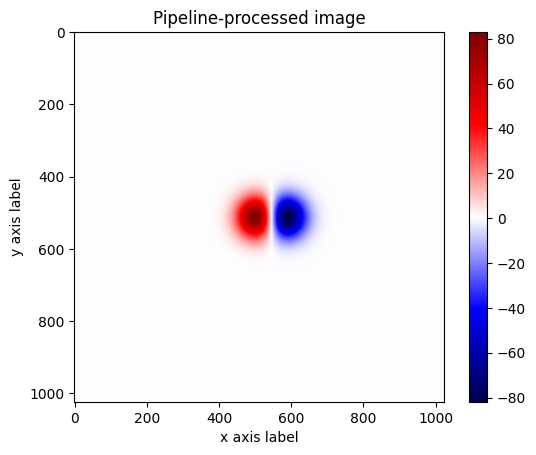

In [4]:
from semantiva.specializations.image.image_viewers import ImageViewer

# --- Display the Processed Image ---
# Visualize the pipeline-processed image using ImageViewer.
# The display settings include:
#   - title: Sets a descriptive title for the image.
#   - xlabel: Label for the x-axis.
#   - ylabel: Label for the y-axis.
#   - cmap: Colormap used for visualization ("seismic" enhances separation of negative and positive values).
#   - colorbar: Displays a colorbar to indicate the mapping of data values.
ImageViewer.view(
    processed_image,
    title="Pipeline-processed image",
    xlabel="x axis label",
    ylabel="y axis label",
    cmap="seismic",
    colorbar=True,
)

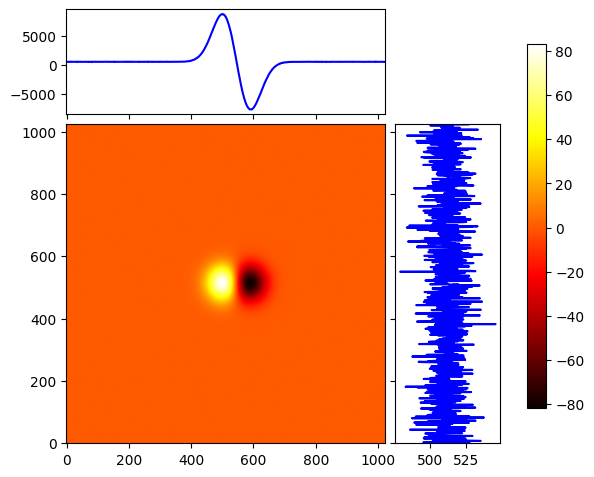

In [5]:
from semantiva.specializations.image.image_viewers import ImageXYProjectionViewer

# --- Display XY Projections of the Processed Image ---
# Visualize the XY projections of the processed image using ImageXYProjectionViewer.
# This viewer helps reveal the distribution of pixel intensities along the horizontal (X) and vertical (Y) axes.
ImageXYProjectionViewer.view(processed_image)

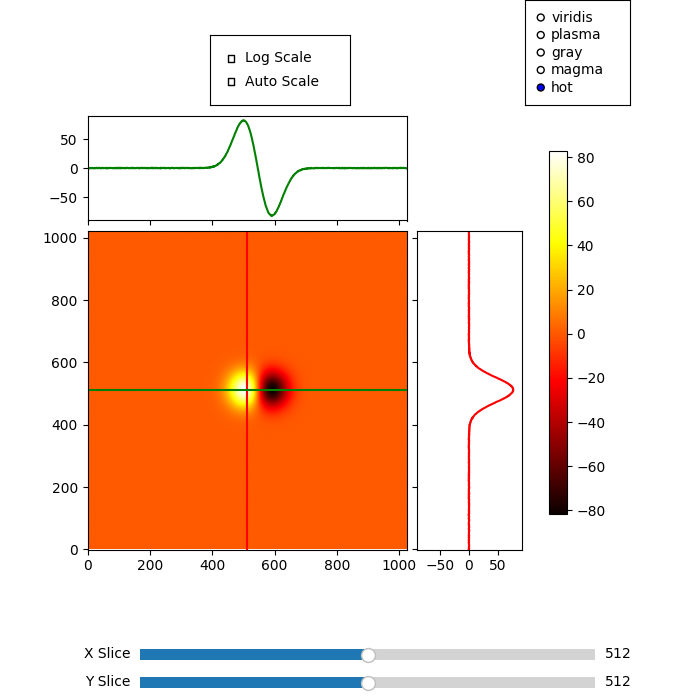

In [6]:
# Enable interactive matplotlib mode using the ipympl backend.
# NOTE: Using `%matplotlib ipympl` alters the appearance and behavior of matplotlib plots
# in the notebook. This is required for the interactive capabilities of the ImageCrossSectionInteractiveViewer.
%matplotlib ipympl

from semantiva.specializations.image.image_viewers import ImageCrossSectionInteractiveViewer

# --- Launch Interactive Cross-Section Viewer ---
# Use the ImageCrossSectionInteractiveViewer to interactively explore cross-section slices
# of the processed image. This tool allows you to dynamically inspect the intensity profiles
# along specific sections, enhancing your understanding of spatial variations.
ImageCrossSectionInteractiveViewer.view(processed_image)